In [1]:
import numpy as np
import scipy as sc
import control.matlab as co
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import ipywidgets as widgets
%matplotlib notebook

import warnings #Hide warnings regarding imaginary plots - NOT RECOMMENDED for normal use
warnings.filterwarnings('ignore')

In [2]:
s = co.tf([1,0],[0,1]) # equivalent to s = tf('s') in matlab

# Vehicle Steering Control using Y-K Parameterization

This Project is done by Thomas Chu of the Dept. of Mechanical Engineering at UW as a part of ME599 Frequency domain design and control in Spring 2020. The full paper is at this **link**. The paper will be referenced extensively to explain process involved in the following code. 

In this analysis, inverse-based Youla Kucera parameterization method is used to design a filter to reject wheel wobble disturbances on a vehicle steering system. The filter works best at rejecting sinusoidal disturbance at 𝟖𝟎 radians per second, and the filter reduces the magnitude of the disturbance up to 180 radians per second.

**Note**: The analysis below does not include derivations. It is left for explanation in the paper. It only provides interactive tools to visualize effects of parameters on filters and disturbance rejection. It does not include adding feedforward model inversion with Zero Phase Error Tracking as done in final sections of the paper. 

## 1 - System Dynamics and Linearization

### 1.1 - Vehical Dynamics

The vehicle model is simplified using the bicycle model in fig. 1. The following definitions are used for deriving the
kinematics of the vehicle:
    
- $a$ - length of the rear wheel to center of mass
- $b$ - length of the wheel base
- $𝑏_w$ - width of the wheel base
- $r$ - turning radius length from point O to the center of mass
- $\delta$ - steering angle direction
- $\delta_0$ - steering angle of the outer-front tire
- $\delta_i$ - steering angle of the inner-front tire
- $\alpha$ - slip angle
- $V$ - vehicle velocity
- $\theta$ - vehicle direction relative to the X-axis
- $\psi$ - heading of the vehcile
    

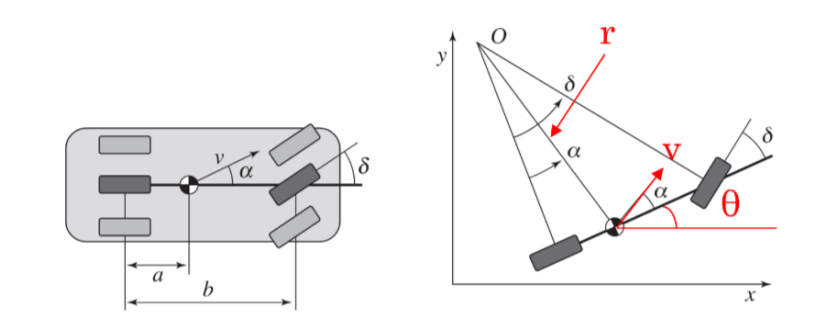
<div align="center"> Fig. 1 - Vehicle model (Left) and Bicycle model (Right)</div>

The bicycle model is used under the assumption that the steering angle is small. The inner and outer tires have different
steering angles when turning since the inner and outer front wheels do not share the same axis to point O in fig 2. Using
Ackerman’s steering geometry, the inner and outer steering angle is approximated assuming the steering angle is small.

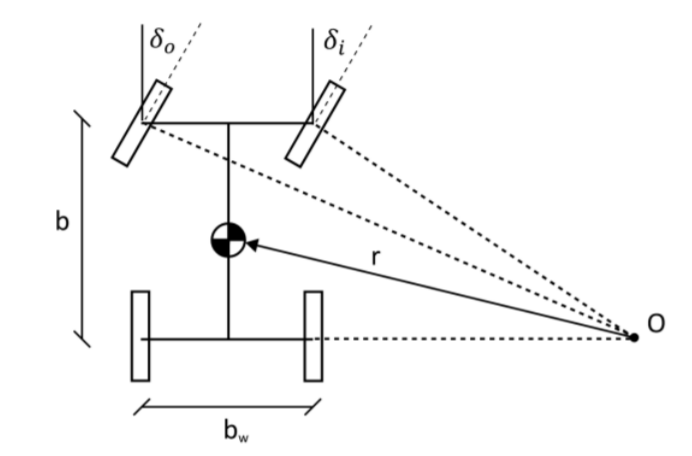
<div align="center"> Fig. 2 - Ackerman steering model</div>

Solving the vehicle dynamics gives the equations:
$$ \dot{x} = V [ cos(\alpha (\delta) + \theta )] \;\;\;\;\;\;\;\;\;\; [1] $$

$$ \dot{y} = V [ cos(\alpha (\delta) + \theta)] \;\;\;\;\;\;\;\;\;\; [2] $$

$$ \dot{\theta} = \frac{V}{b} [tan(\delta) cos(\alpha(\delta))] \;\;\;\;\;\; [3]$$


### 1.2 - Linearization

Using Jacobian linearization as done in the paper, we get the following state space equations:

$$ A = \left[ \matrix{0 & V_0 \\ 0 & 0}\right], \;\;\;\;\;\;\;\; B = \left[ \matrix{\frac{a}{b} V_0 \\ \frac{V_0}{b}}\right], \;\;\;\;\;\;\;\; C = \left[ \matrix{1 & 0 \\0 & 1}\right], \;\;\;\;\;\;\;\; D = \left[ \matrix{0 \\0} \right] $$

The code below is a function that will return the state space matrices. It is recommended to use functions to create a neat looking program which has a good flow. 

In [3]:
def linear_system(V0,a,b):
    """ Creates the state space matrices of the system model as defined in the referred paper.
    
            Inputs: 
                    V0 = Vehicle Velocity
                    a  = Length of the rear wheel to center of mass
                    b  = Width of the wheel base
            Returns:
                    A, B, C, D = System state space matrices
    """
    
    A = np.array([[0,V0],[0,0]])
    
    B = np.array([[a/b*V0],[V0/b]])
    C = np.array([[1,0],[0,1]])
    D = np.array([[0],[0]])
    
    return A,B,C,D

The Code below has parameter creation code and then calls the linear_system function to create the state space matrices.

In [4]:
# Creating OL system and extracting y

# Parameters required for system definition
a = 2.5   
b = 5
V0 = 30

# Create Matrices
A,B,C,D = linear_system(V0,a,b)

# Create System
sys = co.ss(A,B,C,D)

# Extract the y transfer function and convert is to TF for further analysis
sys_y = sys[0,0]
Gy_ol = co.ss2tf(sys_y)
P = Gy_ol

## 2 - Analysis & Control

### 2.1 - Baseline Controller, C (PI)

The code below creates a PI controller, which will be the baseline controller, C, for the Youla-Kucera parameterization and plots the step response of the system.

<IPython.core.display.Javascript object>


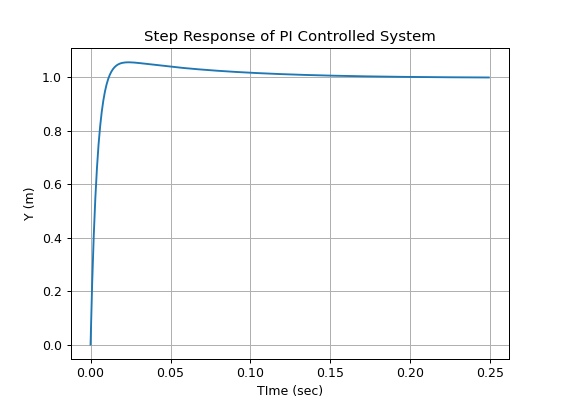

Text(0, 0.5, 'Y (m)')

In [5]:
# PI Controller

# Controller Parameters
L = 0.05
T = 0.95
Kp = 0.9*T/L
Ti = L/0.3
Td = 0

C_ct = Kp*(1 + 1/(Ti*s) + Td*s) # subscript CT stands for Continuous Time

Gy_cl = co.feedback(C_ct*Gy_ol,1) # Close the loop with feedback

# Plot the step response of the CL system with feedback
plt.figure(1,figsize = [7,5])
T1 = np.arange(0,0.25,0.001)
[X,T1] = co.step(Gy_cl,T1)
plt.plot(T1,X); # using semicolon at the end will remove the single line text description output that plots have 

plt.grid()
plt.title("Step Response of PI Controlled System")
plt.xlabel("TIme (sec)")
plt.ylabel("Y (m)")


Now that we have designed a baseline controller and the system has good response, why do we bother with further analysis? One of the main results of Youla-Kucera Parameterization is the disturbance rejection model. The above system will not handle disturbances effectively. Some disturbances on the road include bumps, high winds, uneven roads. For this analysis, bumps are considered because they cause wheel wobble which can be felt on the steering wheel by the driver.

The bumps considered have a frequency of 80 rad/s and a magnitude of 1. 

#### Defining DT Parameters for future use

In [6]:
fs = 160 # Sampling frequency
Ts = 1/fs # Sampling time
z = co.tf([1,0],[0,1],Ts) # Similar to z = tf('z') in matlab

### 2.2 - Filter Design Using Y-K Parameterization

Refer to Heading IV *Sections A and B* in the paper to understand the derivation of the filter design.

The code below is a function that will be executed when the slider below the plots is changed. This function also has every step in filter design as the system definition needs to change when the parameters are changed.

In [14]:
def slider_change(change):
    
    global alpha, C_all, P_dt # So it is callable outside the function
    global wn
    
    alpha = slider_alpha.value # Assign new Slider Value to alpha
    m = 1                      # Relative Degree
    Zm = z**-m         
    
    P_dt = co.c2d(P,Ts,'zoh') # Discretize OL Plant
    invP = P_dt**-1*Zm        # Inverse P
    
    wn = slider_omega.value        # Disturbance Frequency
    w_dt = wn*Ts              
    
    # For bode plots in python, define a frequency range for a smooth plot that would capture all the characteristics.
    omega_range = np.arange(0.001,1000,0.1) # Range of frequencies to be calculated for bodel plot
    Q_math = 2*np.cos(w_dt) - z**-1 # Q Design mathematic
    
    # Q Filter design with p-z cancellation
    Q = co.minreal(((2-2*alpha)*np.cos(w_dt)+(alpha**2-1)*z**-1)/(1-2*alpha*np.cos(w_dt)*z**-1+alpha**2*z**-2))
    
    # A Filter
    A = 1 - Zm*Q
    
    # Calculate bode of A for omega_range
    magA,phaseA,omegaA = co.bode(A,omega_range)
    fig2.clf()   # Using bode command automatically plots on any figure available. Therefore, clear the figure after running
                 # I have created separate ways to show the bode plots so that they can fit in the subplots properly with other graphs
    
    # Convert Controller to DT
    C_dt = co.c2d(C_ct,Ts)
    
    # Sensitivity Function without Q Filter
    S_dt = co.minreal(1/(1+P_dt*C_dt))
    
    # Extract Bode values of Sensitivity Function
    magS_dt, phaseS_dt, omegaS_dt = co.bode(S_dt,omega_range)
    fig2.clf()
    
    # Sensivity Function with Q Filter connected 
    S_dt_q = co.minreal(1/(1+P_dt*C_dt)*(1-z**-m*Q))
    
    # Bode Plot of Sensitivity Function
    magS_dt_q, phaseS_dt_q, omegaS_dt_q = co.bode(S_dt_q,omega_range)
    fig2.clf()
    
    # All Stabilizing Parameterization
    C_all = co.minreal((C_dt + invP*Q)/(1-Zm*Q))
    
    # Closed loop system with C_all
    G_cl = co.feedback(P_dt*C_all,1)
    G_cl = co.minreal(G_cl)
    
    # Step response of Closed loop system
    T = np.arange(0,0.5,Ts)
    [T,Y] = co.step(G_cl,T)
    
    # PLOTTING ALL RESULTS
    
    # Create Axes for subplots on the same figure
    ax_fig2_1 = fig2.add_subplot(111, position = [0.1, 0.75, 0.35, 0.2])
    ax_fig2_2 = fig2.add_subplot(211, position = [0.1, 0.50, 0.35, 0.2])
    ax_fig2_3 = fig2.add_subplot(121, position = [0.55, 0.75, 0.35, 0.2])
    ax_fig2_4 = fig2.add_subplot(122, position = [0.55, 0.5, 0.35, 0.2]) 
    ax_fig2_5 = fig2.add_subplot(111, position = [0.1,0.05, 0.8,0.35])
    
    # Plot A Filter Magnitude vs. Frequency ( Semi-log plot)
    ax_fig2_1.semilogx(omegaA, 20*np.log10(magA));
    ax_fig2_1.set_title("Filter Bode Plot");
    ax_fig2_1.set_ylabel("Magnitude (dB)");
    ax_fig2_1.grid();
    
    # Plot A Filter Phase vs. Frequency ( Semi-log plot)
    ax_fig2_2.semilogx(omegaA,phaseA*180/np.pi);
    ax_fig2_2.set_xlabel("Frequency (rad/sec)");
    ax_fig2_2.set_ylabel("Phase (deg)");
    ax_fig2_2.grid();
    
    # Plot S Magnitude vs. Frequency ( Semi-log plot)
    ax_fig2_3.semilogx(omegaS_dt, 20*np.log10(magS_dt));      # Without Q 
    ax_fig2_3.semilogx(omegaS_dt_q, 20*np.log10(magS_dt_q));  # With Q
    ax_fig2_3.set_title("Sensitivity: Normal vs with Q");
    ax_fig2_3.set_ylabel("Magnitude (dB)");
    ax_fig2_3.legend(["Without Q", "with Q"])
    ax_fig2_3.grid();
    
    # Plot S omega vs. Frequency ( Semi-log plot)
    ax_fig2_4.semilogx(omegaS_dt,phaseS_dt*180/np.pi);      # Without Q
    ax_fig2_4.semilogx(omegaS_dt_q,phaseS_dt_q*180/np.pi);  # With Q
    ax_fig2_4.set_xlabel("Frequency (rad/sec)");
    ax_fig2_4.set_ylabel("Phase (deg)");
    ax_fig2_4.grid();
    
    # Final System Step Response
    ax_fig2_5.step(Y,T); #For DT Plot, use step function in matplotlib. Otherwise, it will be sharp pointed lines connecting points
    ax_fig2_5.set_xlabel("Time (sec)");
    ax_fig2_5.set_ylabel("Y (m)");
    ax_fig2_5.grid();
    ax_fig2_5.set_title("Closed Loop Response with $C_{all}$");
    

Now we have the defined function for execution on slider change. The code below is to initialize the figure and slider.

<IPython.core.display.Javascript object>


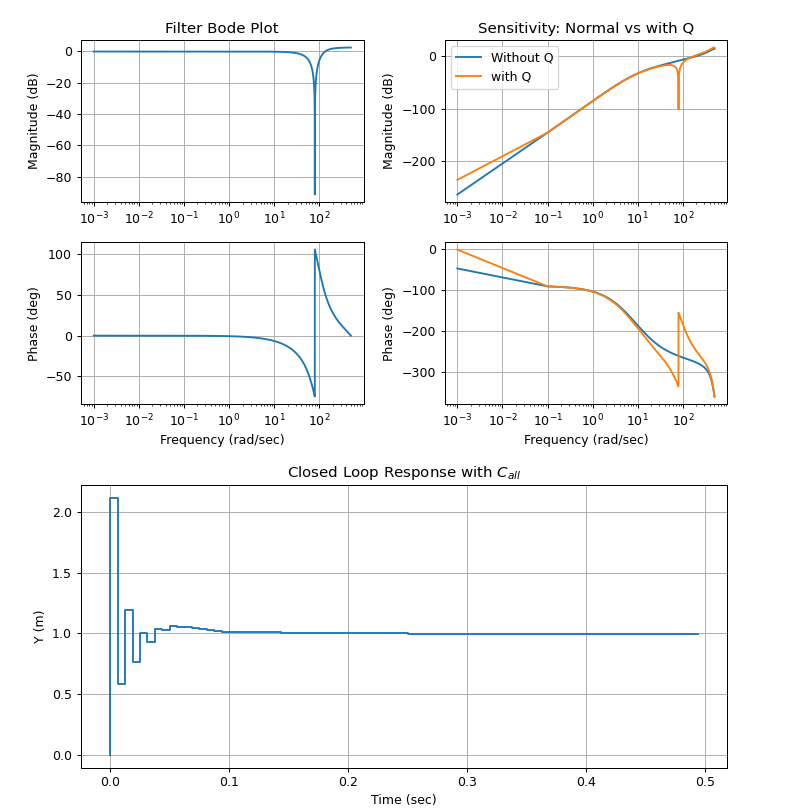

FloatSlider(value=0.0, continuous_update=False, description='$alpha$', max=1.0, step=0.01)

FloatSlider(value=0.0, continuous_update=False, description='$omega$', step=1.0)

2 states have been removed from the model
0 states have been removed from the model
1 states have been removed from the model
4 states have been removed from the model
1 states have been removed from the model
2 states have been removed from the model
0 states have been removed from the model
1 states have been removed from the model
4 states have been removed from the model
1 states have been removed from the model


In [15]:
# Create Figure and Subplot axes
fig2 = plt.figure(2,figsize = [10,10])
ax_fig2_1 = fig2.add_subplot(111, position = [0.1,0.75, 0.8,0.2] )
ax_fig2_2 = fig2.add_subplot(121, position = [0.1,0.50, 0.8,0.2] )
ax_fig2_3 = fig2.add_subplot(111, position = [0.1,0.05, 0.8,0.35] )
ax_fig2_4 = fig2.add_subplot(122, position = [0.55, 0.5, 0.35, 0.2]) 
ax_fig2_5 = fig2.add_subplot(111, position = [0.1,0.05, 0.8,0.35])

# Slider for Alpha
slider_alpha = widgets.FloatSlider(value=0, min=0, max=1, step=0.01,description='$alpha$',continuous_update=False) # Create slider with parameters
slider_alpha.observe(slider_change, 'value') # Link the slider to update function

# Slider for Omega
slider_omega = widgets.FloatSlider(value=0, min=0, max=100, step=1,description='$omega$',continuous_update=False) # Create slider with parameters
slider_omega.observe(slider_change, 'value')

# Display Sliders
display(slider_alpha, slider_omega)

### 2.3 - Sinusoidal Acceleration Input (Desired Trajectory)

This function creates a sinusoidal acceleration input for a desired trajectory. See the plot below for the output. The acceleration has the equation

$$ \ddot{x} = A sin(\omega T) = A sin( \frac{2\pi}{T}t) $$

Integrate to find Velocity and Displacement.

In [9]:
def sinusoidal_acc(t_i,t_f,tmax,y_i,y_f,Tend):
    T = t_f - t_i # Time period
    A = (y_f - y_i)*2*np.pi/(T*T) # Amplitude
    t = np.arange(0,tmax,0.00625) # Time vector
    
    ad = 0*t # Initialize Acc
    vd = 0*t # Initialize Vel
    xd = 0*t # Initialize dis
    
    for i in range(0,len(t),1):
        
        if t[i] < t_i:
            ad[i] = 0 # No acc before the start time
            vd[i] = 0
            xd[i] = 0
            
        elif t[i] < t_i + T:
            tt = t[i] - t_i # Current Time 
            ad[i] = A*np.sin(2*np.pi*tt/T) 
            vd[i] = (A*T/(2*np.pi))*(1 - np.cos(2*np.pi*tt/T))
            xd[i] = y_i + (A*T/(2*np.pi))*tt  -(A*T*T/(4*np.pi**2))*np.sin(2*np.pi*tt/T)
            
        else:
            ad[i] = 0
            vd[i] = 0
            xd[i] = 1
            
    return xd,vd,ad,t


Create the desired trajectory vector

<IPython.core.display.Javascript object>


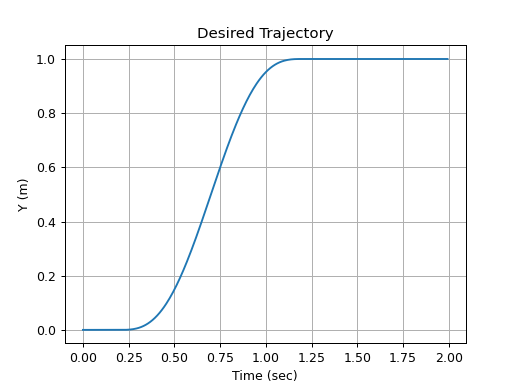

In [11]:
T = 1; # T is the time period in second
Npre = 0.2 
Npost = 0.8 # pre and post actuaction time

Tend = T+Npre+Npost # Ending point for plotting
y_final = 1;
yd,ydd,yd2d,t =  sinusoidal_acc(Npre,(Npre+T),(Npre+T+Npost), 0, y_final, Tend);

# Plot the desired Trajectory
fig3 = plt.figure(3)
plt.plot(t,yd);
plt.grid()
plt.title("Desired Trajectory");
plt.xlabel("Time (sec)");
plt.ylabel("Y (m)");

### 2.4 - System Interconnections

See the Aircraft Control notebook for explanation on System interconnections.

In [12]:
dist = z/z #Create a constant multiplier for disturbance input. 

# Append the systems together. Make sure they are in Statespace form
appended = co.append(co.ss(P_dt),co.ss(C_all),dist) 

# Assign Inputs. All the subsystems are SISO. any MIMO system would have multiple inputs/outputs and the order must be cared for.
inputs = np.array([[2],[3]]) #Inputs to Controller and Disturbance

# Assign Outputs. The only output is from the Plant
outputs = np.array([1]) 

# Connections
# [2,-1,0] = input terminal 2 (controller) receives negative feedback (-) from output terminal 1 (Plant output) and nothing (0) from output terminal 3. 
# [1,2,3] =  input terminal 1 (Plant) receives signal from output terminal 2 and 3. 
connections = np.array([[2,-1,0],[1,2,3]])

#Make final connections using arrays created above
sys_final = co.connect(appended,connections,inputs,outputs) 

### 2.5 - Simulation: No Disturbance

In [18]:
# Simulate System without Disturbance
yout, T, xout = co.lsim(sys_final[0,0], yd, t)

<IPython.core.display.Javascript object>


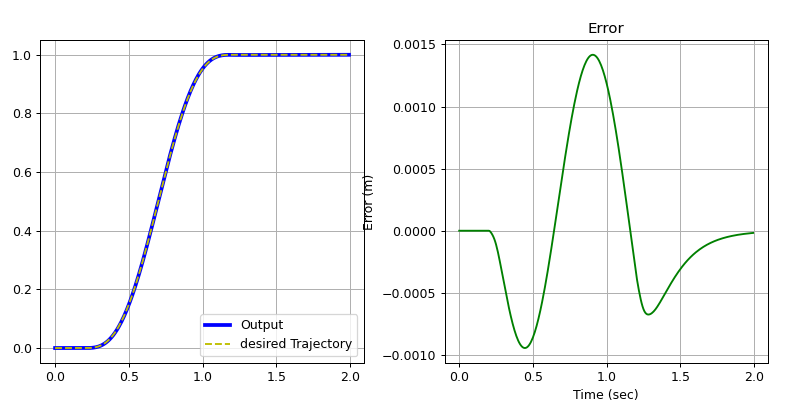

Text(0, 0.5, 'Error (m)')

In [19]:
fig4 = plt.figure(4, figsize = [10,5])
ax_fig4_1 = fig4.add_subplot(111, position = [0.05, 0.1, 0.4,0.8] )
ax_fig4_2 = fig4.add_subplot(111, position = [0.55, 0.1, 0.4,0.8] )
ax_fig4_1.plot(T,yout,'b',linewidth=3)
ax_fig4_1.plot(t,yd,'y--')
ax_fig4_1.legend(["Output","desired Trajectory"])
ax_fig4_1.grid()
ax_fig4_2.set_xlabel("Time (sec)")
ax_fig4_2.set_ylabel("Response (m)")

ax_fig4_2.plot(t,yout-yd,'g')
ax_fig4_2.set_title("Error")
ax_fig4_2.grid()
ax_fig4_2.set_xlabel("Time (sec)")
ax_fig4_2.set_ylabel("Error (m)")

### 2.6 - Simulation: Sinusoidal disturbance 

The filter design frequency is based on the slider value above. ANother slider below modulates disturbance frequency.

In [48]:
# Disturbance SLider update function
def dist_slider(change):
    plt.clf()
    
    wn = slider_dist.value # New disturbance value
    disturbance_input = np.sin(wn*t) # Input disturbance vector
    yout2, T2, xout2 = co.lsim(sys_final[:,1], disturbance_input, t) #Simulate system design for input disturbance
    
    # Plot System
    ax_fig5_1 = fig5.add_subplot(111, position = [0.05, 0.05, 0.4, 0.8])
    ax_fig5_2 = fig5.add_subplot(121, position = [0.55, 0.05, 0.4, 0.8])
    
    # Plot Left plot 
    ax_fig5_1.grid()
    ax_fig5_1.plot(t,yout2)
    ax_fig5_1.plot(t,disturbance_input)
    ax_fig5_1.legend(["Output Y","Disturbance"])
    ax_fig5_1.set_title("Response to Disturbance")
    
    # Plot right Plot
    ax_fig5_2.grid()
    ax_fig5_2.plot(t,yout2)
    ax_fig5_2.set_title("Response Y Magnified")

<IPython.core.display.Javascript object>


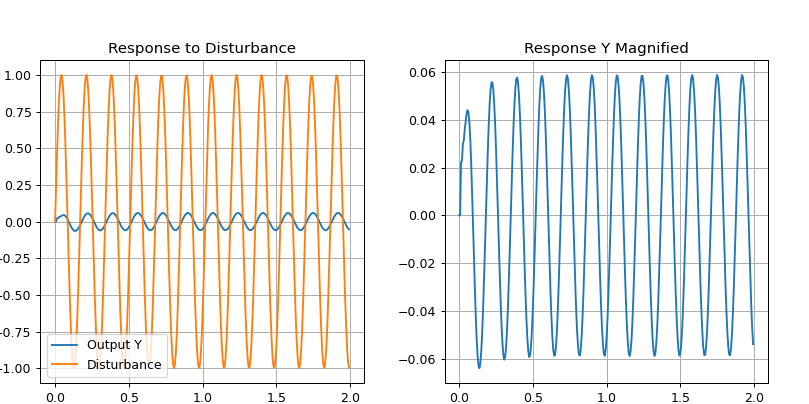

FloatSlider(value=0.0, continuous_update=False, description='$omega$', step=1.0)

In [49]:
# Initialize Figure
fig5 = plt.figure(5, figsize = [10,5])
ax_fig5_1 = fig5.add_subplot(111, position = [0.05, 0.05, 0.4, 0.8])
ax_fig5_2 = fig5.add_subplot(121, position = [0.55, 0.05, 0.4, 0.8])

# Createa nd display slider
slider_dist = widgets.FloatSlider(value=0, min=0, max=100, step=1,description='$omega$',continuous_update=False) # Create slider with parameters
slider_dist.observe(dist_slider, 'value') # Link the slider to update function

display(slider_dist)

The result above shows that when the frequency of the disturbance matches the Filter design, the response to the disturbance goes to zero. This is a really good application to areas where disturbance is a problem, such as hard-disk design. The response is low for frequencies around the design frequency. This notch width depends on the $\alpha$ value.